# Black Scholes Call Options Pricing using Deep Neural Networks

## Synthetic Call Options Data using Black-Scholes

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as si
import matplotlib.pyplot as plt
import random

random.seed(42)

In [2]:
def black_scholes(S, X, T, r, sigma, option_type="call"):
    d1 = (np.log(S / X) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))     # Calculating d1 and d2
    d2 = d1 - sigma * np.sqrt(T)
    if option_type == "call":
        option_price = S * si.norm.cdf(d1, 0.0, 1.0) - X * np.exp(-r * T) * si.norm.cdf(d2, 0.0, 1.0) # Call option
    elif option_type == "put":
        option_price = X * np.exp(-r * T) * si.norm.cdf(-d2, 0.0, 1.0) - S * si.norm.cdf(-d1, 0.0, 1.0) # Put Option
    
    return option_price

In [3]:
def generate_data(num_samples=1000):
    # fixed range 
    time_to_maturity_values = [0.25/12, 1/12, 3/12, 6/12, 9/12, 1, 2, 3] 
    volatility_values = [0.25, 0.5, 0.75] 
    interest_rate_values = [0.04, 0.045, 0.05]  

    # Generate dataset 
    data = []
    for T in time_to_maturity_values:
        for sigma in volatility_values:
            for r in interest_rate_values:
                for _ in range(num_samples):  
                    # Randomize stock price and strike price
                    S = np.random.uniform(50, 300) 
                    X = np.random.uniform(50, 300)  
                    option_type = "call"
                    
                    option_price = black_scholes(S, X, T, r, sigma, option_type)
                    data.append([round(S, 4), round(X, 4), round(T, 4), round(r, 4), round(sigma, 4), option_type, round(option_price, 4)])
    
    # to df
    df = pd.DataFrame(data, columns=["Stock Price", "Strike Price", "Time to Maturity", "Risk-Free Rate", "Volatility", "Option Type", "Option Price"]) 
    return df

# Generated data df
df =  generate_data(num_samples=1000)
df.to_csv('generated_call_options_data.csv')

## Step 1: Preprocessing the Data

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For data splitting and preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# For building the neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1_l2

# For evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error

# For the Black-Scholes formula
from scipy.stats import norm

# For hyperparameter tuning
import keras_tuner as kt

In [5]:
# Input features and target variable
X = df[["Stock Price", "Strike Price", "Time to Maturity", "Risk-Free Rate", "Volatility"]].values
y = df["Option Price"].values

In [6]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### Tranforming the training and test data 

In [7]:
# scalers initialization
scaler_X = StandardScaler()
scaler_y = StandardScaler()

# transform training data
X_train_scaled = scaler_X.fit_transform(X_train)
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()

# Transform test data
X_test_scaled = scaler_X.transform(X_test)
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

print(f"Shape of y_test: {y_test.shape}")

Shape of y_test: (14400,)


#### Neural Network Architecture 

In [8]:
def build_ffn_model(hp):
    """
    Builds a Feedforward Neural Network model with hyperparameters specified by Keras Tuner.

    Parameters:
    - hp: HyperParameters object from Keras Tuner

    Returns:
    - Compiled Keras model
    """
    model = Sequential()
    # Tune the number of units in the first Dense layer
    units = hp.Choice('units', values=[32, 64, 128])
    # Tune the activation function
    activation = hp.Choice('activation', values=['relu', 'tanh'])
    # Tune the dropout rate
    dropout_rate = hp.Choice('dropout_rate', values=[0.0, 0.2])
    # Tune regularization parameters
    l1_reg = hp.Choice('l1_reg', values=[0.0, 0.001])
    l2_reg = hp.Choice('l2_reg', values=[0.0, 0.001])

    # Input and first hidden layer
    model.add(Dense(units=units, activation=activation,
                    input_shape=(X_train_scaled.shape[1],),
                    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    if dropout_rate > 0:
        model.add(Dropout(rate=dropout_rate))

    # Second hidden layer
    model.add(Dense(units=units, activation=activation,
                    kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
    if dropout_rate > 0:
        model.add(Dropout(rate=dropout_rate))

    # Output layer
    model.add(Dense(units=1, activation='linear'))

    # Tune the learning rate
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005])

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model


### Hyperparameterization

In [9]:
from keras_tuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

tuner = RandomSearch(
    build_ffn_model,
    objective='val_loss',
    max_trials=10,  # Total number of models to try
    executions_per_trial=1,  # Number of times to train each model
    directory='hyperparameter_tuning',
    project_name='ffn_option_pricing'
)

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(X_train_scaled, y_train_scaled,
             epochs=50,
             validation_split=0.1,
             callbacks=[early_stopping],
             verbose=1)



Reloading Tuner from hyperparameter_tuning/ffn_option_pricing/tuner0.json


In [10]:
# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal #units: {best_hps.get('units')},
the optimal activation function: {best_hps.get('activation')},
the optimal dropout rate: {best_hps.get('dropout_rate')},
the optimal l1 regularization: {best_hps.get('l1_reg')},
the optimal l2 regularization: {best_hps.get('l2_reg')},
the optimal learning rate for the optimizer:  {best_hps.get('learning_rate')}.
""")


The optimal #units: 128,
the optimal activation function: relu,
the optimal dropout rate: 0.0,
the optimal l1 regularization: 0.0,
the optimal l2 regularization: 0.0,
the optimal learning rate for the optimizer:  0.0005.



In [11]:
# model with best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Training
history = model.fit(X_train_scaled, y_train_scaled,
                    epochs=50,
                    validation_split=0.1,
                    callbacks=[early_stopping],
                    verbose=1)


Epoch 1/50


/Users/karandeepsonewane/Library/Python/3.11/lib/python/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 381us/step - loss: 0.0620 - val_loss: 0.0014
Epoch 2/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 375us/step - loss: 7.7371e-04 - val_loss: 4.5079e-04
Epoch 3/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 315us/step - loss: 3.3333e-04 - val_loss: 2.2707e-04
Epoch 4/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 328us/step - loss: 2.6223e-04 - val_loss: 7.3404e-04
Epoch 5/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 366us/step - loss: 2.4135e-04 - val_loss: 1.3835e-04
Epoch 6/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 368us/step - loss: 1.7647e-04 - val_loss: 3.0627e-04
Epoch 7/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 374us/step - loss: 1.4794e-04 - val_loss: 1.1724e-04
Epoch 8/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 347us/step - loss: 1.4356e-04 - val_loss: 8.1083e-05
Epoch 9/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 0s 304us/step - loss: 1.3640e-04 - val_loss: 8.4337e-05
Epoch 10/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - loss: 1.1468e-04 - val_loss: 1.1586e-04
Epoch 11/50
1620/1620 ━━━━━━━━━━━━━━━━

# Model Evaluation

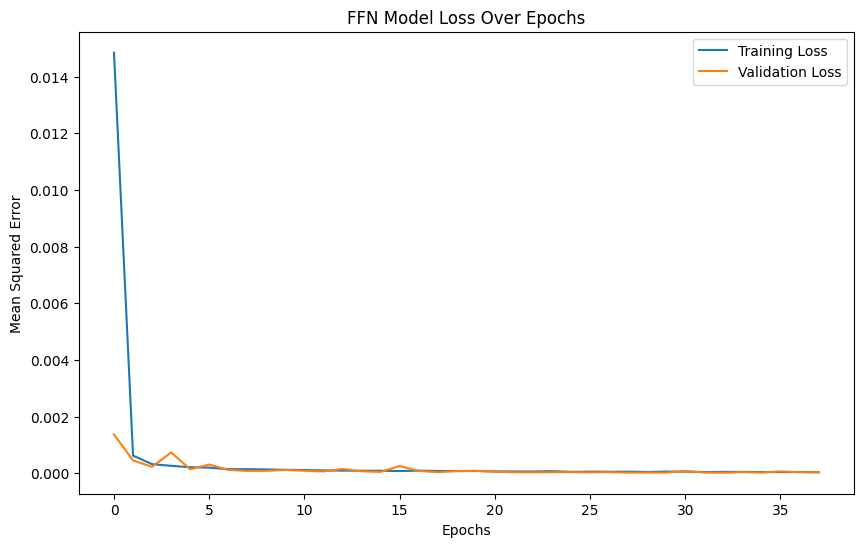

In [12]:
# Plot the training and validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('FFN Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


In [13]:
# Predict on the test set
y_pred_scaled = model.predict(X_test_scaled)
# Inverse transform the predictions
y_pred_ffn = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Check the shape again
print(f"Shape of y_test: {y_test.shape}")
print(f"Shape of y_pred: {y_pred_ffn.shape}")


450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 274us/step
Shape of y_test: (14400,)
Shape of y_pred: (14400,)


In [14]:
# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test, y_pred_ffn)
mae = mean_absolute_error(y_test, y_pred_ffn)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")



Test MSE: 0.0609
Test MAE: 0.1912


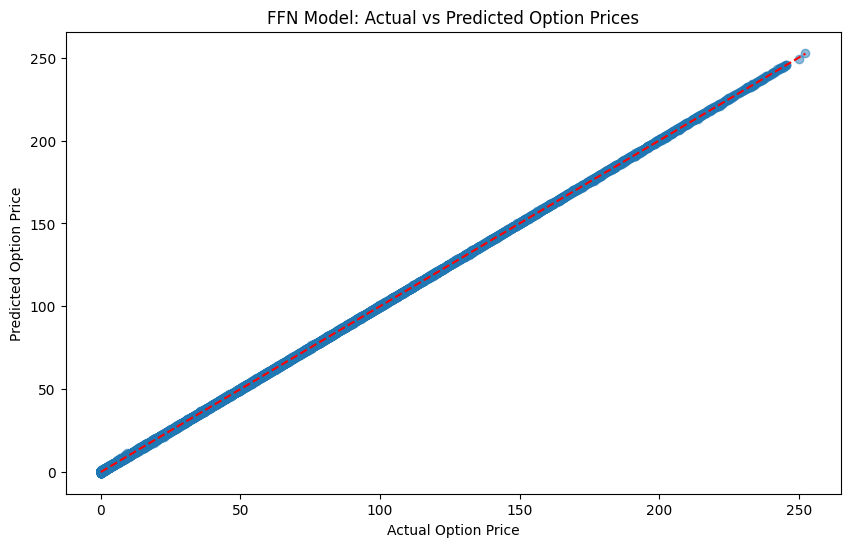

In [15]:
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_ffn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Option Price')
plt.ylabel('Predicted Option Price')
plt.title('FFN Model: Actual vs Predicted Option Prices')
plt.show()


In [16]:
# Save trained model
model.save('ffn_option_pricing_model.h5')

# ResNET model

In [17]:
def build_resnet_model(hp):
    """
    Builds a Residual Neural Network model with hyperparameters specified by Keras Tuner.

    Parameters:
    - hp: HyperParameters object from Keras Tuner

    Returns:
    - Compiled Keras model
    """
    # Hyperparameters to tune
    units = hp.Choice('units', values=[32, 64, 128])
    num_blocks = hp.Int('num_blocks', min_value=2, max_value=5, step=1)
    activation = hp.Choice('activation', values=['relu', 'tanh'])
    dropout_rate = hp.Choice('dropout_rate', values=[0.0, 0.2])
    l2_reg = hp.Choice('l2_reg', values=[0.0, 0.001])
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005])

    # Input layer
    inputs = Input(shape=(X_train_scaled.shape[1],))
    x = Dense(units=units, activation=activation,
              kernel_regularizer=l1_l2(l2=l2_reg))(inputs)
    x = LayerNormalization()(x)

    # Residual blocks
    for _ in range(num_blocks):
        shortcut = x
        # First layer in the block
        x = Dense(units=units, activation=activation,
                  kernel_regularizer=l1_l2(l2=l2_reg))(x)
        x = LayerNormalization()(x)
        if dropout_rate > 0:
            x = Dropout(rate=dropout_rate)(x)
        # Second layer in the block
        x = Dense(units=units, activation=None,
                  kernel_regularizer=l1_l2(l2=l2_reg))(x)
        x = LayerNormalization()(x)
        # Skip connection
        x = Add()([shortcut, x])
        x = Activation(activation)(x)

    # Output layer
    outputs = Dense(units=1, activation='linear')(x)

    # Create the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model


### Hyperparameter Tuning using Keras

In [18]:
tuner = RandomSearch(
    build_resnet_model,
    objective='val_loss',
    max_trials=10,  # Total number of models to try
    executions_per_trial=1,  # Number of times to train each model
    directory='hyperparameter_tuning',
    project_name='resnet_option_pricing'
)


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

tuner.search(X_train_scaled, y_train_scaled,
             epochs=50,
             validation_split=0.1,
             callbacks=[early_stopping],
             verbose=1)

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f""" The hyperparameter search is complete. The optimal number of units is {best_hps.get('units')},
Optimal number of residual blocks is {best_hps.get('num_blocks')},
Optimal activation function is {best_hps.get('activation')},
Optimal dropout rate is {best_hps.get('dropout_rate')},
Optimal l2 regularization is {best_hps.get('l2_reg')},
Optimal learning rate for the optimizer is {best_hps.get('learning_rate')}.
""")


Reloading Tuner from hyperparameter_tuning/resnet_option_pricing/tuner0.json
 The hyperparameter search is complete. The optimal number of units is 64,
Optimal number of residual blocks is 2,
Optimal activation function is tanh,
Optimal dropout rate is 0.0,
Optimal l2 regularization is 0.0,
Optimal learning rate for the optimizer is 0.0005.



### Training the model with best hyperparameters

In [19]:
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense, Dropout, LayerNormalization, Add, Activation
from tensorflow.keras.models import Model
# model with best hyperparameters
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train_scaled, y_train_scaled,
                    epochs=50,
                    validation_split=0.1,
                    callbacks=[early_stopping],
                    verbose=1)


Epoch 1/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 2s 693us/step - loss: 0.0914 - val_loss: 0.0057
Epoch 2/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 608us/step - loss: 0.0038 - val_loss: 0.0024
Epoch 3/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 667us/step - loss: 0.0024 - val_loss: 0.0014
Epoch 4/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step - loss: 0.0018 - val_loss: 0.0024
Epoch 5/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 585us/step - loss: 0.0015 - val_loss: 0.0011
Epoch 6/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 7/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 606us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 8/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 628us/step - loss: 9.7351e-04 - val_loss: 5.2212e-04
Epoch 9/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 603us/step - loss: 8.0739e-04 - val_loss: 3.5768e-04
Epoch 10/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 484us/step - loss: 7.1878e-04 - val_loss: 9.4731e-04
Epoch 11/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 481us/step - loss: 6.6631e-04

### Evaluate the Model

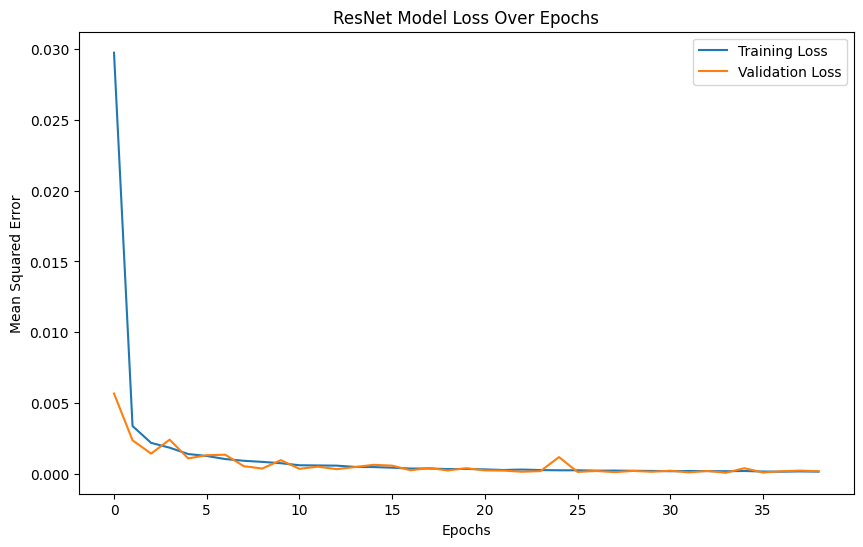

In [20]:
# Plot the training and validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ResNet Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()


### on test data 

In [21]:
# Predict on test set
y_pred_scaled = model.predict(X_test_scaled)
# Inverse transform the predictions
y_pred_rsn = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step


### Performance of the prediction

Test MSE: 0.2148
Test MAE: 0.3537


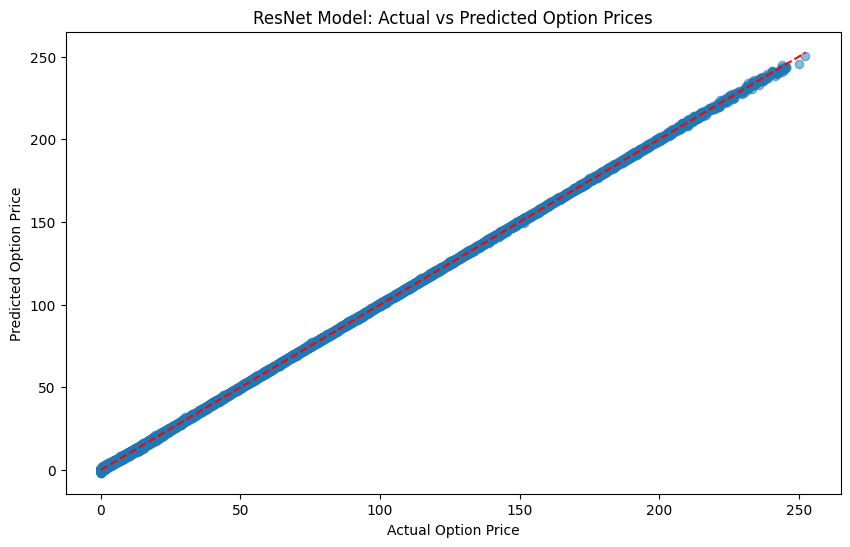

In [22]:
# Calculate Mean Squared Error and Mean Absolute Error
mse = mean_squared_error(y_test, y_pred_rsn)
mae = mean_absolute_error(y_test, y_pred_rsn)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rsn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Option Price')
plt.ylabel('Predicted Option Price')
plt.title('ResNet Model: Actual vs Predicted Option Prices')
plt.show()


In [23]:
# Save the trained model
model.save('resnet_option_pricing_model.h5')


## RBFN Model
##### Radial Basis Function Networks use radial basis functions as activation functions. We'll define a custom RBF layer and then create a model-building function for hyperparameter tuning.

In [24]:
from tensorflow.keras.layers import Input, Dense, Layer
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import RandomUniform
# Custon RBF model
class RBFLayer(Layer):
    def __init__(self, units, initializer=None, **kwargs):
        super(RBFLayer, self).__init__(**kwargs)
        self.units = units
        self.initializer = initializer if initializer is not None else RandomUniform(minval=-1, maxval=1)


    def build(self, input_shape):
        # Centers (prototypes)
        self.centers = self.add_weight(
            name='centers',
            shape=(self.units, input_shape[-1]),
            initializer=self.initializer,
            trainable=True
        )
        # Betas (inverse of widths)
        self.betas = self.add_weight(
            name='betas',
            shape=(self.units,),
            initializer='ones',
            trainable=True
        )
        super(RBFLayer, self).build(input_shape)

    def call(self, inputs):
        # Expand dimensions for broadcasting
        C = K.expand_dims(self.centers, axis=0)  # Shape: (1, units, features)
        H = K.expand_dims(inputs, axis=1)        # Shape: (batch_size, 1, features)
        distances = K.sum((H - C) ** 2, axis=-1)  # Squared Euclidean distance
        outputs = K.exp(-self.betas * distances)
        return outputs


In [25]:
### Model Building function 
def build_rbfn_model(hp):
    """
    Builds a Radial Basis Function Network model with hyperparameters specified by Keras Tuner.

    Parameters:
    - hp: HyperParameters object from Keras Tuner

    Returns:
    - Compiled Keras model
    """
    # Hyperparameters to tune
    units = hp.Choice('units', values=[32, 64, 128])
    # Tune the number of RBF units
    rbf_units = hp.Choice('rbf_units', values=[10, 20, 30, 40, 50, 100])
    # Tune the learning rate
    learning_rate = hp.Choice('learning_rate', values=[0.001, 0.0005])
    # Tune regularization parameters
    l1_reg = hp.Choice('l1_reg', values=[0.0, 0.001])
    l2_reg = hp.Choice('l2_reg', values=[0.0, 0.001])

    # Input layer
    inputs = Input(shape=(X_train_scaled.shape[1],))
    # RBF Layer
    x = RBFLayer(units=rbf_units)(inputs)
    # Dense layer after RBF layer
    x = Dense(units=units, activation='linear',
              kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg))(x)
    # Output layer
    outputs = Dense(units=1, activation='linear')(x)

    # Create 
    model = Model(inputs=inputs, outputs=outputs)

    # Compile 
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mean_squared_error')

    return model


In [26]:
### Hyperparameter Tuning ------------------------
from keras_tuner import RandomSearch

tuner = RandomSearch(
    build_rbfn_model,
    objective='val_loss',
    max_trials=10,  # Total number of models to try
    executions_per_trial=1,  # Number of times to train each model
    directory='hyperparameter_tuning',
    project_name='rbfn_option_pricing'
)


early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuner.search(X_train_scaled, y_train_scaled,
             epochs=50,
             validation_split=0.1,
             callbacks=[early_stopping],
             verbose=1)



Reloading Tuner from hyperparameter_tuning/rbfn_option_pricing/tuner0.json


In [27]:
# best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
optimal #RBF units: {best_hps.get('rbf_units')},
Optimal #units in Dense layer: {best_hps.get('units')},
Optimal l1 regularization: {best_hps.get('l1_reg')},
Optimal l2 regularization: {best_hps.get('l2_reg')},
Optimal learning rate for optimizer: {best_hps.get('learning_rate')}.
""")


optimal #RBF units: 20,
Optimal #units in Dense layer: 128,
Optimal l1 regularization: 0.0,
Optimal l2 regularization: 0.0,
Optimal learning rate for optimizer: 0.001.



#### Training the RBF Model with the best hyperparameters

In [28]:
# Build the model with the best hyperparameters
model = tuner.hypermodel.build(best_hps)

# Train the model
history = model.fit(X_train_scaled, y_train_scaled,
                    epochs=50,
                    validation_split=0.1,
                    callbacks=[early_stopping],
                    verbose=1)


Epoch 1/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 330us/step - loss: 0.4638 - val_loss: 0.0283
Epoch 2/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 0s 281us/step - loss: 0.0208 - val_loss: 0.0119
Epoch 3/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 0s 298us/step - loss: 0.0112 - val_loss: 0.0092
Epoch 4/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step - loss: 0.0081 - val_loss: 0.0066
Epoch 5/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 0s 272us/step - loss: 0.0064 - val_loss: 0.0062
Epoch 6/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - loss: 0.0059 - val_loss: 0.0067
Epoch 7/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - loss: 0.0056 - val_loss: 0.0077
Epoch 8/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 0s 273us/step - loss: 0.0053 - val_loss: 0.0054
Epoch 9/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - loss: 0.0053 - val_loss: 0.0049
Epoch 10/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 325us/step - loss: 0.0050 - val_loss: 0.0050
Epoch 11/50
1620/1620 ━━━━━━━━━━━━━━━━━━━━ 1s 321us/step - loss: 0.0051 - val_loss: 0.0047
Epoch 12

### Evaluate the rbf model

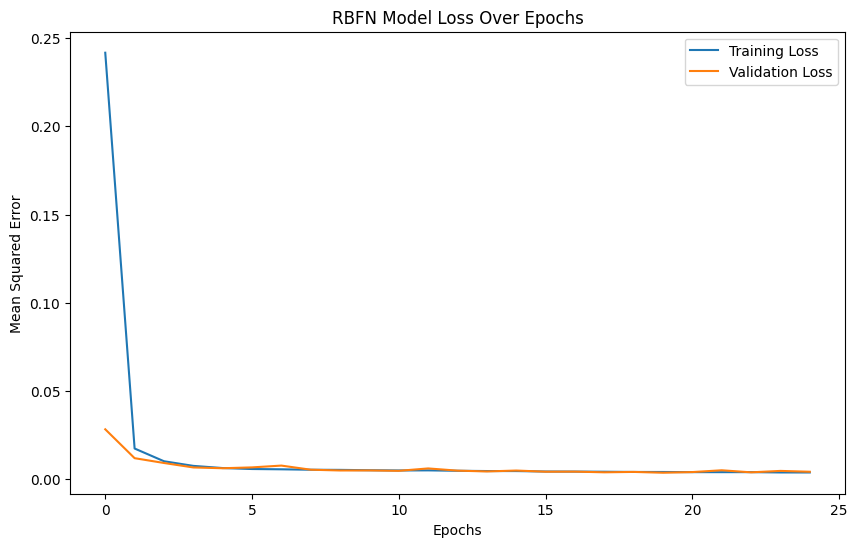

In [29]:
# Plot the training and validation loss
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('RBFN Model Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.show()

In [30]:
# Predict test set
y_pred_scaled = model.predict(X_test_scaled)
# Inverse transform 
y_pred_rbfn = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

450/450 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step


Test MSE: 12.1991
Test MAE: 2.6110


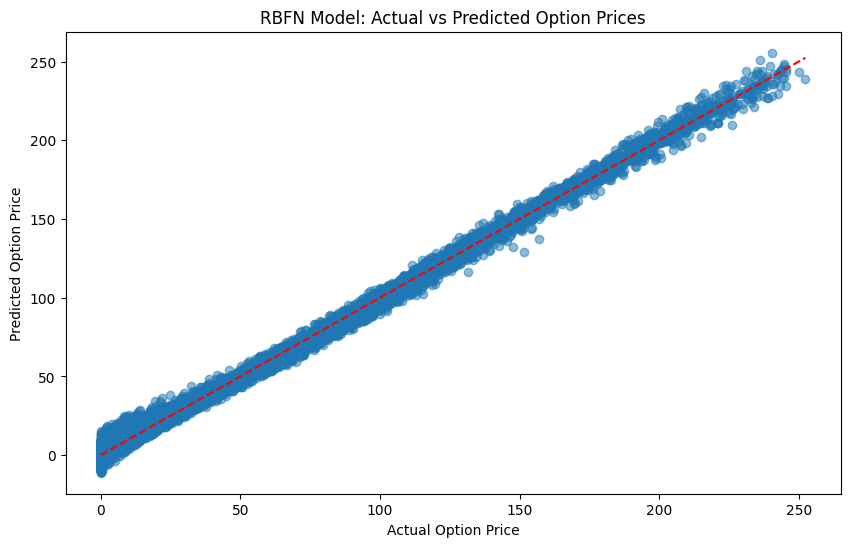

In [31]:
# MSE AND MAE
mse = mean_squared_error(y_test, y_pred_rbfn)
mae = mean_absolute_error(y_test, y_pred_rbfn)

print(f"Test MSE: {mse:.4f}")
print(f"Test MAE: {mae:.4f}")

plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred_rbfn, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Diagonal line
plt.xlabel('Actual Option Price')
plt.ylabel('Predicted Option Price')
plt.title('RBFN Model: Actual vs Predicted Option Prices')
plt.show()


In [32]:
# Save 
model.save('rbfn_option_pricing_model.h5')


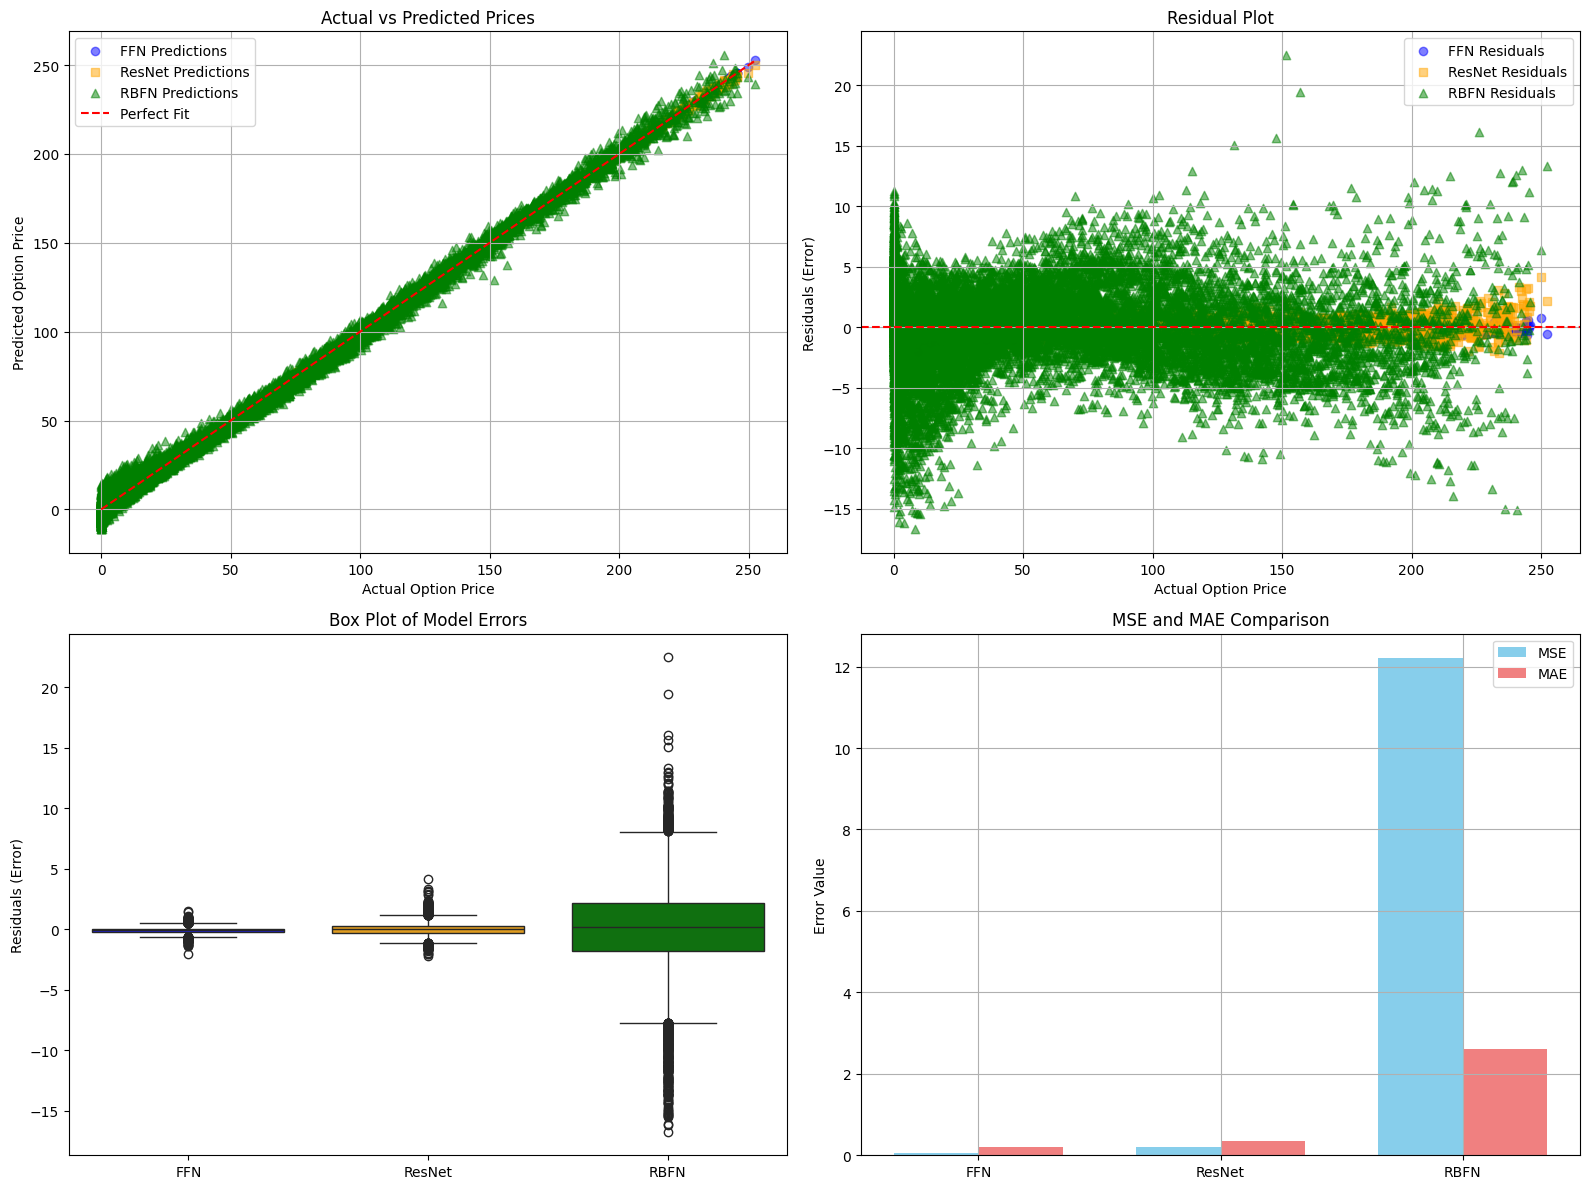

In [33]:
import seaborn as sns

# Calculate residual or error values
residuals_ffn = y_test - y_pred_ffn
residuals_resnet = y_test - y_pred_rsn
residuals_rbfn = y_test - y_pred_rbfn

plt.figure(figsize=(16, 12))

# 1. Actual vs Predicted Plot
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred_ffn, color='blue', alpha=0.5, label='FFN Predictions', marker='o')
plt.scatter(y_test, y_pred_rsn, color='orange', alpha=0.5, label='ResNet Predictions', marker='s')
plt.scatter(y_test, y_pred_rbfn, color='green', alpha=0.5, label='RBFN Predictions', marker='^')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Fit')
plt.xlabel('Actual Option Price')
plt.ylabel('Predicted Option Price')
plt.title('Actual vs Predicted Prices')
plt.legend()
plt.grid(True)

# 2. Residual Plot
plt.subplot(2, 2, 2)
plt.scatter(y_test, residuals_ffn, color='blue', alpha=0.5, label='FFN Residuals', marker='o')
plt.scatter(y_test, residuals_resnet, color='orange', alpha=0.5, label='ResNet Residuals', marker='s')
plt.scatter(y_test, residuals_rbfn, color='green', alpha=0.5, label='RBFN Residuals', marker='^')
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Option Price')
plt.ylabel('Residuals (Error)')
plt.title('Residual Plot')
plt.legend()
plt.grid(True)

# 3. Box Plot of Errors
plt.subplot(2, 2, 3)
sns.boxplot(data=[residuals_ffn, residuals_resnet, residuals_rbfn], palette=['blue', 'orange', 'green'])
plt.xticks([0, 1, 2], ['FFN', 'ResNet', 'RBFN'])
plt.ylabel('Residuals (Error)')
plt.title('Box Plot of Model Errors')

# 4. Bar Plot of MSE and MAE
mse_values = [mean_squared_error(y_test, y_pred_ffn),
              mean_squared_error(y_test, y_pred_rsn),
              mean_squared_error(y_test, y_pred_rbfn)]

mae_values = [mean_absolute_error(y_test, y_pred_ffn),
              mean_absolute_error(y_test, y_pred_rsn),
              mean_absolute_error(y_test, y_pred_rbfn)]

plt.subplot(2, 2, 4)
bar_width = 0.35
indices = np.arange(3)
plt.bar(indices - bar_width / 2, mse_values, bar_width, color='skyblue', label='MSE')
plt.bar(indices + bar_width / 2, mae_values, bar_width, color='lightcoral', label='MAE')
plt.xticks(indices, ['FFN', 'ResNet', 'RBFN'])
plt.ylabel('Error Value')
plt.title('MSE and MAE Comparison')
plt.legend()
plt.grid(True)

# Display the plots
plt.tight_layout()
plt.show()
